<img src="unicamp.png" height="128" width="128">
<h1><center>Brain Extraction in Multiple T1-weighted Magnetic Resonance Imaging slices using Digital Image Processing techniques  </center></h1>  
<h3><center>Autores: </center></h3>
<h3><center>Kauê Tartarotti Nepomuceno Duarte</center></h3>
<h3><center>Marinara Andrade do Nascimento Moura</center></h3>
<h3><center>Paulo Sergio Martins Pedro</center></h3>
<h3><center>Marco Antonio Garcia de Carvalho</center></h3>

### Inicialização

In [1]:
from PIL import Image
from scipy import signal as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_fill_holes, binary_opening
%matplotlib inline
import matplotlib.image as mpimg
from skimage import morphology as morph
from scipy import ndimage as nd
import sys,os
from skimage.filters import threshold_otsu, threshold_isodata, threshold_li, threshold_local, threshold_minimum 
from skimage import feature
from skimage.filters import threshold_local as threshold_adaptative
import heapq
import matplotlib.patches as mpatches
from skimage.morphology import convex_hull_image
import pandas as pd
import seaborn as sns
from scipy.signal import convolve2d as sc_conv
from matplotlib.colors import colorConverter
import matplotlib as mpl
import time

def normalizar(imagem,nDim=1,minNovo=0,maxNovo=255):
    imagem[imagem == -np.inf] = 0
    imagem[imagem == np.inf] = 255
    if nDim == 2:
        l,c = imagem.shape
    max = np.max(imagem.ravel())
    min = np.min(imagem.ravel())
    imagem = np.round(minNovo + (maxNovo - minNovo) *((imagem.ravel() - min)/(max-min)))
    
    if nDim == 2:
        imagem = imagem.reshape(l,c)    
    return imagem

def normalize(f, range=[0,255]):

    f = np.asarray(f)
    range = np.asarray(range)
    if f.dtype.char in ['D', 'F']:
        raise Exception('error: cannot normalize complex data')
    faux = np.ravel(f).astype(float)
    minimum = faux.min()
    maximum = faux.max()
    lower = range[0]
    upper = range[1]
    if upper == lower:
        g = np.ones(f.shape) * maximum
    if minimum == maximum:
        g = np.ones(f.shape) * (upper + lower) / 2.
    else:
        g = (faux-minimum)*(upper-lower) / (maximum-minimum) + lower
    g = g.reshape(f.shape)

    if f.dtype == np.uint8:
        if upper > 255: 
            raise Exception('normalize: warning, upper valuer larger than 255. Cannot fit in uint8 image')
    if lower == 0 and upper == 255:
        g = g.astype(np.uint8)
    else:
        g = g.astype(f.dtype) # set data type of result the same as the input image
    return g

def gaussian(s, mu, cov):
    d = len(s)  # dimension
    n = np.prod(s) # n. of samples (pixels)
    x = np.indices(s).reshape( (d, n))
    xc = x - mu 
    k = 1. * xc * np.dot(np.linalg.inv(cov), xc)
    k = np.sum(k,axis=0) #the sum is only applied to the rows
    g = (1./((2 * np.pi)**(d/2.) * np.sqrt(np.linalg.det(cov)))) * np.exp(-1./2 * k)
    return g.reshape(s)

def magnitude_sobel(image):
    Sv = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sh = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    fv = sc_conv(image,Sv,mode='same')
    fh = sc_conv(image,Sh,mode='same')
    return np.sqrt(fh**2+fv**2)

def save_without_spacing(nome):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import NullLocator
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.savefig(nome, bbox_inches = 'tight',        pad_inches = 0)

<center><h1>Conteúdo</h1></center>

<div class="lev1 toc-item"><a href="#Introdução" data-toc-modified-id="Introdução"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introdução</a></div>
<div class="lev1 toc-item"><a href="#Doença-de-Alzheimer" data-toc-modified-id="Doença-de-Alzheimer"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Doença de Alzheimer</a></div>
<div class="lev1 toc-item"><a href="#Imageamento-Cerebral" data-toc-modified-id="Imageamento-Cerebral"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imageamento Cerebral</a></div>
<div class="lev1 toc-item"><a href="#Problema" data-toc-modified-id="Problema"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Problema</a></div>
<div class="lev1 toc-item"><a href="#Motivação" data-toc-modified-id="Motivação"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Motivação</a></div>
<p>
<div class="lev1 toc-item"><a href="#Metodologia" data-toc-modified-id="Metodologia"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metodologia</a></div>
<div class="lev1 toc-item"><a href="#Aquisição-das-Imagens" data-toc-modified-id="Aquisição-das-Imagens"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Aquisição das Imagens</a></div>
<div class="lev1 toc-item"><a href="#Base-de-Dados-OASIS" data-toc-modified-id="Base-de-Dados-OASIS"><span class="toc-item-num">2.1,1&nbsp;&nbsp;</span>Base de Dados OASIS</a></div>
<div class="lev1 toc-item"><a href="#Escolha-das-Slices" data-toc-modified-id="Escolha-das-Slices"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Escolha das Slices</a></div>
<div class="lev1 toc-item"><a href="#Organização-das-Imagens-nas-Pastas" data-toc-modified-id="Organização-das-Imagens-nas-Pastas"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Organização das Imagens nas Pastas</a></div>
<div class="lev1 toc-item"><a href="#Método" data-toc-modified-id="Método"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Método</a></div>
<div class="lev1 toc-item"><a href="#Leitura-da-Imagem" data-toc-modified-id="Leitura-da-Imagem"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Leitura da Imagem</a></div>
<div class="lev1 toc-item"><a href="#Remoção-do-Cérebro" data-toc-modified-id="Remoção-do-Cérebro"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Remoção do Cérebro</a></div>
<div class="lev1 toc-item"><a href="#Remoção-do-Ruído-do-Fundo" data-toc-modified-id="Remoção-do-Ruído-do-Fundo"><span class="toc-item-num">2.2.2.1&nbsp;&nbsp;</span>Remoção do Ruído do Fundo</a></div>
<div class="lev1 toc-item"><a href="#Ajuste-de-Contraste" data-toc-modified-id="Ajuste-de-Contraste"><span class="toc-item-num">2.2.2.2&nbsp;&nbsp;</span>Ajuste de Contraste</a></div>
<div class="lev1 toc-item"><a href="#Binarização" data-toc-modified-id="Binarização"><span class="toc-item-num">2.2.2.3&nbsp;&nbsp;</span>Binarização</a></div>
<div class="lev1 toc-item"><a href="#Detecção-de-Componente-Conexa" data-toc-modified-id="Detecção-de-Componente-Conexa"><span class="toc-item-num">2.2.2.4&nbsp;&nbsp;</span>Detecção de Componente Conexa</a></div>
<div class="lev1 toc-item"><a href="#Detecção-da-Borda-do-Crânio-via-Canny" data-toc-modified-id="Detecção-da-Borda-do-Crânio-via-Canny"><span class="toc-item-num">2.2.2.5&nbsp;&nbsp;</span>Detecção da Borda do Crânio via Canny</a></div>
<div class="lev1 toc-item"><a href="#Detecção-da-Tonalidade-do-Fundo" data-toc-modified-id="Detecção-da-Tonalidade-do-Fundo"><span class="toc-item-num">2.2.2.6&nbsp;&nbsp;</span>Detecção da Tonalidade do Fundo</a></div>
<div class="lev1 toc-item"><a href="#Detecção-da-Parte-Central-do-Cérebro-(sem-fundo)" data-toc-modified-id="Detecção-da-Parte-Central-do-Cérebro-(sem-fundo)"><span class="toc-item-num">2.2.2.7&nbsp;&nbsp;</span>Detecção da Parte Central do Cérebro (sem fundo)</a></div>
<div class="lev1 toc-item"><a href="#Verificação-da-Presença-da-Intensidade-da-Borda-no-Centro" data-toc-modified-id="Verificação-da-Presença-da-Intensidade-da-Borda-no-Centro"><span class="toc-item-num">2.2.2.8&nbsp;&nbsp;</span>Verificação da Presença da Intensidade da Borda no Centro</a></div>
<div class="lev1 toc-item"><a href="#Extração-da-Componente-Conexa" data-toc-modified-id="Extração-da-Componente-Conexa"><span class="toc-item-num">2.2.2.9&nbsp;&nbsp;</span>Extração da Componente Conexa</a></div>
<div class="lev1 toc-item"><a href="#Criação-do-Agrupamento-de-Componentes-Conexas" data-toc-modified-id="Criação-do-Agrupamento-de-Componentes-Conexas"><span class="toc-item-num">2.2.2.10&nbsp;&nbsp;</span>Criação do Agrupamento de Componentes Conexas</a></div>
<div class="lev1 toc-item"><a href="#Criação-de-um-Objeto-Convexo" data-toc-modified-id="Criação-de-um-Objeto-Convexo"><span class="toc-item-num">2.2.2.11&nbsp;&nbsp;</span>Criação de um Objeto Convexo</a></div>
<div class="lev1 toc-item"><a href="#Remoção-do-Objeto-Convexo" data-toc-modified-id="Remoção-do-Objeto-Convexo"><span class="toc-item-num">2.2.2.12&nbsp;&nbsp;</span>Remoção do Objeto Convexo</a></div>
<p>
<div class="lev1 toc-item"><a href="#Avaliação" data-toc-modified-id="Avaliação"><span class="toc-item-num">3&nbsp;&nbsp;</span>Avaliação</a></div>
<div class="lev1 toc-item"><a href="#Métricas" data-toc-modified-id="Métricas"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Métricas</a></div>
<div class="lev1 toc-item"><a href="#Resultados" data-toc-modified-id="Resultados"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Resultados</a></div>
<div class="lev1 toc-item"><a href="#Parte-1---Avaliação-da-Remoção-do-Cérebro-da-Imagem-Original" data-toc-modified-id="Parte-1---Avaliação-da-Remoção-do-Cérebro-da-Imagem-Original"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Parte 1 - Avaliação da Remoção do Cérebro da Imagem Original</a></div>
<p>
<div class="lev1 toc-item"><a href="#Considerações-Finais" data-toc-modified-id="Considerações-Finais"><span class="toc-item-num">4&nbsp;&nbsp;</span>Considerações Finais</a></div>
<div class="lev1 toc-item"><a href="#Principais-Dificuldades" data-toc-modified-id="Principais-Dificuldades"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Principais Dificuldades</a></div>
<div class="lev1 toc-item"><a href="#Contribuições" data-toc-modified-id="Contribuições"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Contribuições</a></div>
<div class="lev1 toc-item"><a href="#Referências" data-toc-modified-id="Referências"><span class="toc-item-num">5&nbsp;&nbsp;</span>Referências</a></div>
<div class="lev1 toc-item"><a href="#Procedimento-Completo-(todas-as-imagens)" data-toc-modified-id="Procedimento-Completo-(todas-as-imagens)"><span class="toc-item-num">6&nbsp;&nbsp;</span>Procedimento Completo (todas as imagens)</a></div>


<h1><center>Introdução</center></h1>

Este trabalho visa realizar a segmentação de Ressonâncias Magnétricas para extrair a região intra-cranial que se localiza entre o crânio e a substância cinzenta. Para realizar este procedimento, foi elaborado um método que aplica diversos conceitos de Processamento de Imagens, que fora basicamente agrupados em: Procedimentos para Remoção do Cérebro; Procedimentos para Remoção do Crânio. Da mesma divisão, foram realizados testes para ambos, no qual a Remoção do Cérebro utilizou o $\textit{Ground Truth}$ da base de dados OASIS, e a Remoção do Crânio realizou a comparação via segmentação manual.

<h3>Imageamento Cerebral</h3>

As imagens de ressonância magnética são obtidas em três diferentes planos: Axial, Coronal e Sagital. Na literatura, normalmente, utiliza-se as imagens axiais para segmentação, devido a melhor representação do cerébro. Esse projeto também utilizará o plano axial para segmentação da região interessada.

<img src="output_Azv9Ec.gif" width=200>


<h3>Problema</h3>

O problema desta trabalho resume-se em criar uma metodologia para extração do cerebro em diversas fatias

<table>
    <tr>
        <th><img src="slice70.png"></th>
        <th><img src="slice100.png"></th>
        <th><img src="slice130.png"></th>
    </tr>
</table>

<h3>Motivação</h3>

A principal motivação do projeto é a possibilidade de através dos resultados obtidos com a segmentação da meninge, contribuir para o avanço dos estudos de prognóstico para a doença de Alzheimer. Com o método, pretende-se extrair a região do cerébro e a região do crânio, para obter a segmentação da meninge. Na literatura, como não é comum encontrar estudos da meninge como um biomarcador, este trabalho poderá contribuir nesse sentido. Além disso, como a extração do cerébro é uma etapa necessária, o processo também é válido para outros estudos já que o cerébro é sempre uma área de interesse para o estudo da doença. Além disso, a avaliação em várias imagens, como será explicado a frente, permitirá que o método seja mais robusto, sendo possível de ser trabalhado em diversas situações.



<center><h1>Metodologia</h1></center>

<h2>Aquisição das Imagens</h2>

<h3><span style="padding-left:2em">Base de Dados OASIS</span></h3>

A base de dados utilizada neste trabalho foi a Open Access Series of Imaging Studies (OASIS)-1: Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults. Esta base é composta de 430 dados de pacientes, entre 18 e 96 anos. Para cada paciente são dispostos determinados dados, tais como: Demográficos: Idade, gênero, educação, status socioeconomico. Clínicos: Mini-Mental State Examination (MMSE), Clinical Dementia Rating (0-2). Derivated anatomic volumes: estimated Total Intracranial Volume (eTIV), Atlas Scaling Factor (ASF), normalized Whole Brain Volume (nWBV). Imageamento: Magnetic Resonance Imaging. Os dados textuais de entrada são todos os descritos anteriormente, que foram organizados em uma tabela para viabilizar a interpretação de programas de mineração de dados.

<h3><span style="padding-left:2em">Escolha das Slices</span></h3>

Para cada Paciente existem 178 imagens no plano axial, as fatias. Dependendo da finalidade de utilização das imagens, algumas das fatias não são interessantes. Para esse projeto, onde interessa-se segmentar a região entre o crânio e o cerébro(meninge), as fatias mais interessante são aquelas acima do cerebelo e abaixo da calota craniana. Assim, escolheu-se o intervalo entre a imagem 070 e a imagem 130, totalizando 60 imagens. Essa escolha permite a análise em um grande número de imagens, tornando o processo mais robusto e possibilitando uma melhor conclusão acerca da utilização do processo de segmentação.

<img src="brainProjection.png">

<h4><span style="padding-left:2em">Organização das Imagens nas Pastas</span></h4>

As imagens obtidas foram organizadas em pastas de acordo com sua origem. Na Aquisição das Imagens, obteve-se as imagens de cada paciente, em cada plano, além do Ground Truth(Imagem do Cerébro). Assim, a organização foi feita por paciente, onde cada paciente tinha as imagens com cerébro(Slices) e  as imagens sem cerébro(Slices No Brain), sendo que em cada uma dessas pastas tinha também cada plano(Axial, Coronal e Sagital).

<table>
    <tr>
        <th><img src="pastas.png"></th>
        <th><img src="axsl.png"></th>
        <th><img src="axslbr.png"></th>
        <th><img src="axslnobr.png"></th>
    </tr>
</table>

<h2>Método</h2>

<h3><span style="padding-left:2em">Leitura da Imagem</span></h3>

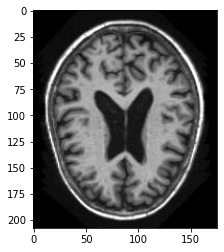

In [35]:
paciente = 'OAS1_0003_MR1'
im1 = Image.open(paciente+'/Slices/Axial/'+paciente+'_axi_095.jpg')
img = np.array(im1)
plt.imshow(img,'gray')

<h3><span style="padding-left:2em">Remoção do Cérebro</span></h3>

<h3><span style="padding-left:4em">Remoção do Ruído do Fundo</span></h3>

As imagens adquiridas na base de dados OASIS possuíam um ruído no fundo, sendo necessário, como uma etapa de pré-processamento removê-lo para então utilizar as imagens. Nesse caso, foi utilizado a equação de uma reta composta por três segmentos.

In [53]:
def three_segments(xa,xb,ya,yb):
    parte1 = np.floor(np.arange(0,ya,ya/(xa+1)))
    parte2 = np.floor(np.arange(ya,yb,(yb-ya)/(xb-xa)))
    parte3 = np.floor(np.arange(yb,255,(255-yb)/(255-xb)))
    mascara = np.hstack((parte1,parte2,parte3))
    return mascara

ruido = three_segments(220,240,50,210)
ruido = ruido[::-1]
#plt.plot(range(0,256),ruido)
#plt.xlabel("gray tone in")
#plt.ylabel("gray tone out")
#save_without_spacing("TrabalhoMeninge_FuncaoRuido.png")

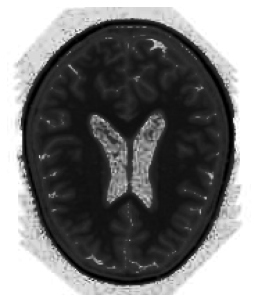

In [54]:
plt.figure(figsize=(4,4))
#plt.title('Ruído')
plt.axis('off')
plt.imshow(ruido[img],'gray')
save_without_spacing("TrabalhoMeninge_Ruido_novo.png")

In [48]:
def remove_ruido_fundo(imagem,Ti=0):
    if Ti==0:
        Ti = np.mean(imagem)
    imagem_filtrada = sci.medfilt(imagem,[3,3])
    ti = imagem_filtrada >Ti
    mascara = binary_fill_holes(ti)

    return [Ti,imagem*mascara]

16642


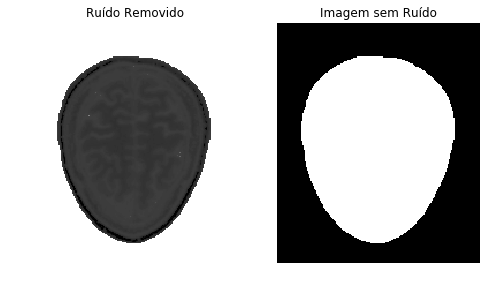

In [49]:
[media,img] = remove_ruido_fundo(img)
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.title('Ruído Removido')
plt.axis('off')
plt.imshow(ruido[img],'gray')
#save_without_spacing("TrabalhoMeninge_RuidoRemovidoInv.png")
plt.subplot(122)
plt.axis('off')
plt.title('Imagem sem Ruído')
plt.imshow(binary_fill_holes(img>0),'gray')
#print(np.sum(binary_fill_holes(img>0)))
#save_without_spacing("TrabalhoMeninge_RuidoRemovido.png")

<h3><span style="padding-left:4em">Ajuste de Contraste</span></h3>

Ainda como etapa de pré-processamento, utilizou-se o algoritmo de Banson e Lajish (2014) para ajustar o contraste da imagem. Os autores comentam a importância de aumentar o contraste das imagens de ressonância magnética, visto que, normalmente, essas imagens possuem baixo contraste, dificultando a análise de maiores detalhes, para fins de diagnóstico.  

Assim, seguiu-se os passos abaixo:

* Passo 1 - Leitura da Imagem A do encefalo
* Passo 2 - Obtém o complemento B da imagem A, através da seguinte função:

<center>$B = A_c = (L-1) - A$, onde $L$ é o valor da maior intensidade</center>

* Passo 3 - Aplicar o operador de fechamento com um disco como elemento estruturante (SE1)

<center>$C = B \bullet SE1$</center>

* Passo 4 - Obtêm o complemento D da imagem C

<center>$D = C_c = (L-1) - C$</center>

* Passo 5 - Calcula a diferença entre a imagem original (A) e a imagem resultante (D)

<center>$A_{diff} = A - D$</center>

* Passo 6 - Adiciona a imagem resultante ($A_{diff}$) a imagem original (A)

<center>$A_{enhanced} = A + A_{diff}$</center>

A primeira etapa foi obter o complemento da imagem original, seguido da operação morfológica de fechamento. A morfologia matemática é uma ferramenta que possibilita a extração de componentes da imagem que podem ser úteis na representação da região. Dessa forma, o fechamento foi aplicado com o intuito de se obter uma imagem  com seções de contornos mais suaves, ou ainda para eliminar pequenos furos e preencher os espaços vazios. Utilizou-se, então o complemento dessa imagem, para calcular a diferença da imagem inicial. Finalmente, adiciou-se esta última à original para obter a imagem com contraste melhorado. 

In [7]:
def ajuste_contraste(img):
    A = img
    L = np.max(A.ravel())
    B = (L-1)-A
    SE1 = morph.ball(3)[3]
    C = morph.closing(B,SE1)
    L = np.max(C.ravel())
    D = (L-1)-C
    Adiff = A-D
    return np.clip(A+Adiff,0,255)

Aenhanced = ajuste_contraste(img)

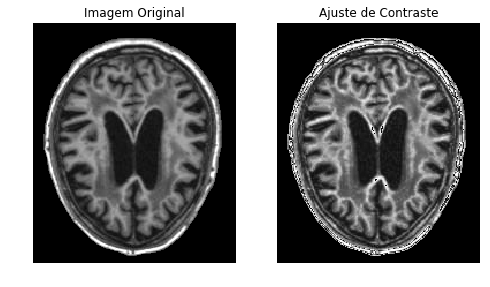

In [8]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.axis('off')
plt.title('Imagem Original')
plt.imshow(img,'gray')
plt.subplot(122)
plt.axis('off')
plt.title('Ajuste de Contraste')
plt.imshow(Aenhanced,'gray')
#save_without_spacing("TrabalhoMeninge_5_IntensidadeAjustada.png")

### Binarização

O processo de Binarização e de encontrar a maior componente conexa também teve origem na metodologia dos autores mencionados, no entanto, no decorrer do processo, percebeu-se a necessidade de adaptação do algoritmo, visto que a região de interesse dos autores era o cerébro, e não a meninge. A binarização foi feita utilizando-se Otsu. Já a ideia de utilizar as componentes conexas foi fundamental para o funcionamento do processo. A função é importada da biblioteca skimage, e funciona retornando todas as regiões conectadas por um mesmo valor de pixel.  Desse modo, o cerébro pode ser detectado como uma componente conexa. 

* Passo 1 - Leitura da Imagem com Contraste Melhorado
* Passo 2 - Binarização da Imagem utilizando Otsu

<center>$G_{bin} = Binarização (A enhanced)$</center>

* Passo 3 - Encontra a maior componente conexa da imagem Binarizada (C1) - Adaptação do Algoritmo de Benson e Lajish(2014)






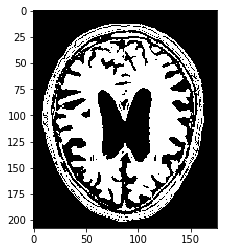

In [9]:
def binariza(imagem,Cerebro=True):
    if Cerebro:
        t = threshold_otsu(imagem)
    else:#Crânio
        t = 0
    imagem_binaria = imagem.copy()
    imagem_binaria[imagem_binaria<=t] = 0
    imagem_binaria[imagem_binaria>t] = 1
    return imagem_binaria

Gbin = binariza(Aenhanced)
plt.imshow(Gbin,'gray')
#save_without_spacing("TrabalhoMeninge_6_Binarizado.png")

<h3><span style="padding-left:4em">Detecção da Componente Conexa</span></h3>

Na detecção das componentes conexas(labels), surgiu alguns problemas, como a proximidade do crânio com o cerébro, em algumas imagens, onde ambos saíam como um único objeto, assim seguiu-se os seguintes passos para resolver o problema:

<h4><span style="padding-left:6em">Detecção da Borda do Crânio via Canny</span></h4>

A detecção da borda do crânio foi necessária para conseguir extrair o cerébro daquelas imagens em que o crânio estava "colado" ao cerébro, e não era possível detectar o cerébro como uma componente conexa única. Utilizou-se o algoritmo de Canny por possuir uma boa detecção, capaz de identificar todas as bordas possíveis na imagem e por desconsiderar os ruídos na criação de bordas. 

<h4><span style="padding-left:6em">Detecção da Tonalidade do Fundo</span></h4>

A tonalidade do fundo foi detectada pegando-se uma região do fundo da imagem com os labels detectados e verificando o indíce de maior intensidade nessa região. Foi necessária para comparar com a parte central, e verificar a ocorrência de pixels do fundo no centro, que causava problemas na identificação da componente conexa. 

<h4><span style="padding-left:6em">Detecção da Parte Central do Cérebro (sem fundo)</span></h4>

De maneira similar, a parte central foi detectada criando-se uma região nessa parte, para detectar exatamente uma região que incluísse o cerébro, tornando possível a distinção dessa componente conexa. Ao detectar a região do fundo, pode-se impor que essa tonalidade não deve estar presente nessa região, garantindo que o pixel mais frequente na região central vai ser apenas o do cerébro.



<h4><span style="padding-left:6em">Verificação da Presença da Intensidade da Borda no Centro</span></h4>

Nesse passo, se os pixels do cerébro estiverem no crânio, é necessário fazer uma operção morfológica de opening com um disco de elemento estruturante, para separar o crânio do cerébro.



Portanto, esse processo, de maneira geral, funciona para detectar as diferentes componentes conexas(labels), garantindo que quando o cerébro estiver muito próximo do crânio, ou "colado" em qualquer outra região, será possível separá-los. 

Text(0.5,1,'Componentes Conexas(labels)')

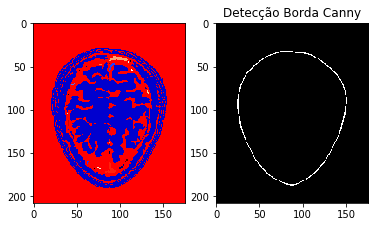

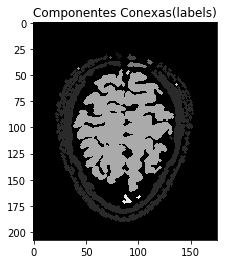

In [29]:
def detecta_borda_conexa(imagem_binaria): 
    cranio_convexo = convex_hull_image(binary_fill_holes(imagem_binaria))# preenche a imagem
    borda_cranio = feature.canny(cranio_convexo)#extrai a borda
    return borda_cranio

def detecta_componente_conexa(imagem_binaria,mostrar_Passos=False):
    label_aux = morph.label(imagem_binaria)
    label_ret = morph.label(imagem_binaria)
    if mostrar_Passos==True:
        plt.figure()
        plt.subplot(121)
        plt.imshow(label_ret,'flag')
        #plt.title('Componentes Conexas(Labels)')
        #save_without_spacing("TrabalhoMeninge_7_"+str(0)+"comp.png")
    valor_disco = 0
    
    #Passo 1 - Detecção da Borda do Crânio via Canny
    contorno_cranio_binario = detecta_borda_conexa(imagem_binaria)
    if mostrar_Passos==True:
        plt.subplot(122)
        plt.imshow(contorno_cranio_binario,'gray')
        plt.title('Detecção Borda Canny')
        plt.figure()

    #Passo 2 - Detecção da Tonalidade do Fundo
    tonalidade_fundo = (np.argmax(np.bincount(label_ret[0:20,0:20].ravel())))
    for ab in range(10):
        #print(ab)
        contorno_cranio = label_ret[contorno_cranio_binario==True]
        [IMX,IMY] = imagem_binaria.shape
        
        #Passo 3 - Detecção da Parte Central do Cérebro (sem fundo)
        array_centro = label_ret[IMX//2-25:IMX//2+25,IMY//2-25:IMY//2+25]
        array_centro = array_centro[array_centro!=tonalidade_fundo]
        max_centro = (np.argmax(np.bincount(array_centro.ravel())))# retorna o pixel mais frequente na imagem array_centro, correspondendo ao valor do cérebro

        #Passo 4 - Verificação da Presença da Intensidade da Borda no Centro 
        if(max_centro in contorno_cranio):
            valor_disco = valor_disco + 1
            label_ret = morph.opening(label_aux,morph.disk(valor_disco))
            label_ret = morph.label(label_ret) 
            #plt.imshow(label_ret)
            #save_without_spacing("TrabalhoMeninge_7_"+str(valor_disco)+"comp.png")            
        else:
            break

    #print(valor_disco)
    if(valor_disco == 0):
        label_ret = label_aux
    return [label_ret,tonalidade_fundo, array_centro]

[LC,tonalidade_fundo,array_centro] = detecta_componente_conexa(Gbin,True)
plt.imshow(LC,'gray')
plt.title('Componentes Conexas(labels)')

<h3><span style="padding-left:4em">Extração da Componente Conexa</span></h3>

Geralmente o fundo é a maior componente conexa, seguida do cerébro. Porém, em alguns casos, o cerébro é tão grande, que é ainda maior que o fundo, ou tão pequeno, que é menor que outras regiões. Assim, verificou-se a necessidade de automatizar o processo, para garantir que a componente conexa extraída fosse sempre o cerébro.

<h4><span style="padding-left:6em">Criação do Agrupamento de Componentes Conexas</span></h4>

Utilizou-se a função "heapq.nlargest" para encontrar as intensidades de pixels que mais se repetiam. Uma dificuldade encontrada nesse procedimento, foi que em alguns casos o cerébro era dividido em duas regiões, criando-se dois labels diferentes para o mesmo cerébro, nessa caso, foi necessário criar uma matriz de substituição, para que quando o cerébro fosse detectado como duas regiões, fosse subsituído por uma única região.



<h4><span style="padding-left:6em">Criação de um Objeto Convexo</span></h4>

Agora, com o cerébro definido como uma região, seria possível extraí-lo da imagem. No entanto, a detecção do cerébro nem sempre é perfeita, ou ainda, em alguns casos, a região é muito desregular. Para uniformizar a região do cerébro, utilizou-se a função "convex_hull_image" da biblioteca skimage, para criar um objeto convexo.  

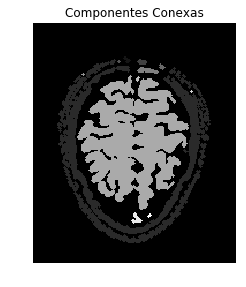

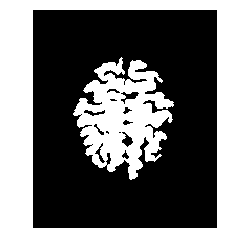

In [30]:
def extrai_maior_componente(LC,tonalidade_fundo,array_centro=0,mostrar_Passos=False):
    #print(type(array_centro))
    c1 = LC.copy()
    
    if mostrar_Passos==True:
        plt.figure(figsize=(8,8))
        plt.subplot(121)
        plt.imshow(c1,'gray')
        plt.axis('off')
        plt.title('Componentes Conexas')
    hist = np.bincount(LC.ravel())
    index = heapq.nlargest(1,range(len(hist)),key=hist.__getitem__)[-1]

    #Se a maior componente conexa for o fundo, pegue a segunda maior componente
    if index == tonalidade_fundo:
        index = heapq.nlargest(2,range(len(hist)),key=hist.__getitem__)[-1]

    #Rerotulação das componentes conexas baseado na ocorrencia de pixels no centro
    if type(array_centro) == np.ndarray:
        matriz_substituicao = np.isin(c1,np.unique(array_centro[array_centro!=tonalidade_fundo]))
        c1_k = convex_hull_image(matriz_substituicao)
        if mostrar_Passos==True:
            plt.figure()
            plt.imshow(matriz_substituicao,'gray')
            plt.axis('off')
            #plt.title('Agrupamento Conexo')
            #save_without_spacing("TrabalhoMeninge_8_Agrupamento.png")
        return [matriz_substituicao,c1_k]
        #c1[matriz_substituicao] = index


    c1[c1==index] = 1000
    c1[c1<1000] = 0
    c1[c1==1000] = 1
    c1_k = convex_hull_image(c1)
    return [c1,c1_k]

[c1,c1_k] = extrai_maior_componente(LC,tonalidade_fundo,array_centro,True)


<h3><span style="padding-left:4em">Remoção do Objeto Convexo</span></h3>

Finalmente, é possível remover a componente cerébro da imagem, restando agora o crânio e a meninge. O próximo passo será remover o crânio, para obter a região de interesse.

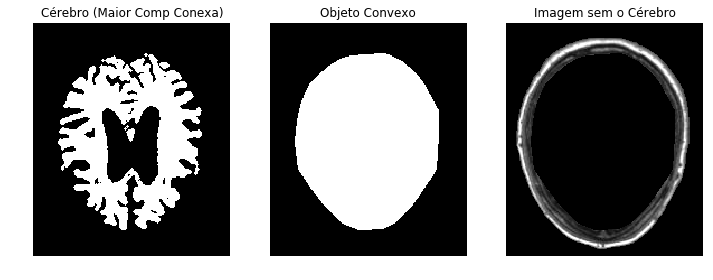

In [12]:
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(c1,'gray')
plt.axis('off')

plt.title('Cérebro (Maior Comp Conexa)')
plt.subplot(132)
plt.imshow(c1_k,'gray')
plt.axis('off')
plt.title('Objeto Convexo')
#save_without_spacing("TrabalhoMeninge_9_Convexo.png")
plt.subplot(133)
final_img = img-(img*c1_k)
plt.axis('off')
plt.title('Imagem sem o Cérebro')
plt.imshow(final_img,'gray')
#save_without_spacing("TrabalhoMeninge_9_ConvexoFinal.png")

<h1><center>Avaliação</center></h1>

Para avaliar a abordagem, comparou-se as imagens obtidas com o Ground Truth, em duas etapas. Primeiramente, comparou-se as imagens obtidas com o Ground Truth da imagem sem o cérebro(obtida diretamente da base de dados). Na segunda etapa, comparou-se 7 das imagens obtidas de um paciente escolhido aleatoriamente com o GroundTruth da imagem sem o crânio, segmentada manualmente no software Interactive Segmentation Tool.

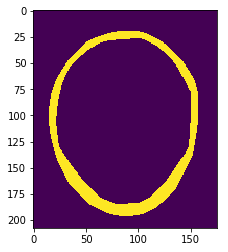

<Figure size 432x288 with 0 Axes>

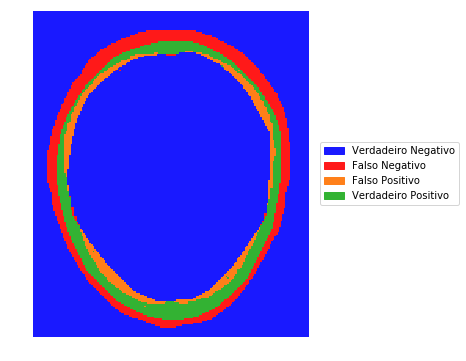

In [18]:
import matplotlib.pyplot as plt

im1 = Image.open(paciente+'/SlicesNoBrain/Axial/'+paciente+'_axi_gt_100.jpg')
img2 = np.array(im1)
[mediax,img2] = remove_ruido_fundo(img2,media)
imgOUR = imagem_final>1
plt.figure()
plt.imshow(imgOUR)
plt.figure()
imgGT = img2>20
confusion_matrix = imgGT + 2*imgOUR

t = 1 ## alpha value
cmap = {1:[0.1,0.1,1.0,t],2:[1.0,0.1,0.1,t],3:[1.0,0.5,0.1,t],4:[0.2,0.7,0.2,t]}
labels = {1:'Verdadeiro Negativo',2:'Falso Negativo',3:'Falso Positivo',4:'Verdadeiro Positivo'}
arrayShow = np.array([[cmap[i] for i in j] for j in confusion_matrix+1])    
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

plt.figure(figsize=(6,6))
plt.imshow(arrayShow)
plt.legend(handles=patches, loc=5, borderaxespad=-15)
plt.axis('off')
#plt.title('Ground Truth')
plt.show()
#save_without_spacing("TrabalhoMeninge_13_GroundTruth.png")

<h2><span style="padding-left:2em">Métricas</span></h2>

As métricas utilizadas nesse trabalho consideraram a Precisão, Revocação, F-score, Acurácia e Especificidade, baseadas na Matriz de Confusão, que calcula a quantidade de falso positivo e falso negativo; e de verdadeiro positivo e verdadeiro negativo.

A precisão mede os valores positivos que foram identificados corretamente; 

<center><h2>$P = \frac{TP}{TP+FP}$</center>

A Revocação é a taxa de verdadeiros positivos;

 <center><h2>$R = \frac{TP}{TP+FN}$</center>

O F-score é a média harmónica de precisão e revocação;

 <center><h2>$F = 2 \times \frac{P*R}{P+R}$</center> 

A acurácia é mede a proporção de casos que foram corretamente previstos, sejam eles verdadeiro positivo ou verdadeiro negativo;

 <center><h2>$A = \frac{TP+TN}{TP+TN+FP+FN}$</center>

A especificidade é a taxa de verdadeiros negativos.

<center><h2>$S = \frac{TN}{FP+TN}$</center>
  


In [39]:
[TN,FN,FP,TP] = np.bincount(confusion_matrix.ravel())
np.bincount(confusion_matrix.ravel())
print(TN,FN,FP,TP)

precision = TP/(TP+FP) 
recall = TP/(TP+FN)
fmeasure = 2*(precision*recall)/(precision+recall)
accuracy = (TP+TN)/(TP+FP+FN+TN)
specificity = TN/(FP+TN)

print('Precision: ',precision)
print('Recall: ',recall)
print('F-Score: ',fmeasure)
print('Accuracy: ',accuracy)
print('Specificity: ',accuracy)

30310 760 208 5330
Precision:  0.9624413145539906
Recall:  0.8752052545155994
F-Score:  0.9167526659786722
Accuracy:  0.9735576923076923


<h2><span style="padding-left:2em">Resultados</span></h2> 

<h3><span style="padding-left:2em">Parte 1 - Avaliação da Remoção do Cérebro da Imagem Original</span></h3> 

Estabelecida as métricas de avaliação, realizou-se a avaliação para todas as imagens(430 pacientes - 61 fatias), gerando o gráfico abaixo. 
Todas as imagens tiveram suas métricas acima de 70%, onde as métricas melhores avaliadas foram as de Acurácia e Especificidade, que ficaram entre 95% e 100%, aproximadamente.

C:\Users\kaueu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


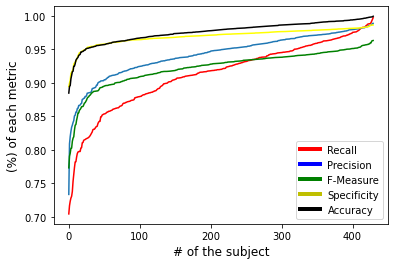

In [22]:
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
metrics = np.load('metrics.npy')
metrics = metrics[:,:-1,:]

recall = np.sort(np.mean(metrics[:,:,0],axis=1))
precision = np.sort(np.mean(metrics[:,:,1],axis=1))
fmeasure = np.sort(np.mean(metrics[:,:,2],axis=1))
specificity = np.sort(np.mean(metrics[:,:,3],axis=1))
accuracy = np.sort(np.mean(metrics[:,:,4],axis=1))

mean = (np.vstack((recall,precision,fmeasure,specificity,accuracy)))
mean = mean.T
df = pd.DataFrame(mean,columns=['Recall','Precision','F-Measure','Specificity','Accuracy'])

#plt.figure(figsize=(15,18))
#plt.subplot(511)
#plt.figure(figsize=(12,4))
fig, ax = plt.subplots()
sns.lineplot(x=range(len(recall)),y=recall,color='red')
#save_without_spacing("TrabalhoMeninge_Exp1_Recall.png")
#plt.title('Recall')
#plt.subplot(512)
#plt.figure(figsize=(12,4))
sns.lineplot(range(len(recall)),y=precision)
#save_without_spacing("TrabalhoMeninge_Exp1_Precision.png")
#plt.title('Precision')
#plt.subplot(513)
#plt.figure(figsize=(12,4))
sns.lineplot(x=range(len(recall)),y=fmeasure,color='green')
#save_without_spacing("TrabalhoMeninge_Exp1_FMeasure.png")
#plt.title('F-Measure')
#plt.subplot(514)
#plt.figure(figsize=(12,4))
sns.lineplot(x=range(len(recall)),y=specificity,color='yellow')
#save_without_spacing("TrabalhoMeninge_Exp1_Specificity.png")
#plt.title('Specificity')
#plt.subplot(515)
#plt.figure(figsize=(12,4))
sns.lineplot(x=range(len(recall)),y=accuracy,color='black')

legend_elements = [Line2D([0], [0], color='r', lw=4, label='Recall'),
                   Line2D([0], [0], color='b', lw=4, label='Precision'),
                  Line2D([0], [0], color='g', lw=4, label='F-Measure'),
                  Line2D([0], [0], color='y', lw=4, label='Specificity'),
                  Line2D([0], [0], color='k', lw=4, label='Accuracy'),]

# Create the figure

ax.legend(handles=legend_elements, loc='lower right')

ax.set_xlabel('# of the subject', fontsize=12)
ax.set_ylabel('(%) of each metric', fontsize=12)
#save_without_spacing("TrabalhoMeninge_Exp1.png")
#plt.title('Accuracy')


plt.axis('on')
plt.savefig('TrabalhoMeninge_Exp1.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

#plt.figure(figsize=(7,5))
#sns.heatmap(np.corrcoef([recall,precision,fmeasure,specificity,accuracy]),xticklabels=['R','P','F','S','A'],yticklabels=['R','P','F','S','A'])
#save_without_spacing("TrabalhoMeninge_Exp1_Corr.png")

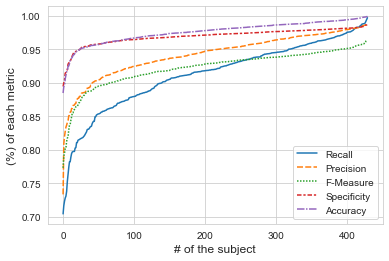

In [36]:
#plt.figure(figsize=(12,8))
sns.set_style("whitegrid")

l = sns.lineplot(data=df)

l.set_xlabel("# of the subject", fontsize = 12)
l.set_ylabel("(%) of each metric", fontsize = 12)
#plt.set_xlabel('', fontsize=12)
#plt.set_ylabel('', fontsize=12)
plt.axis('on')
plt.savefig('TrabalhoMeninge_Exp1.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [19]:
#df[df['Recall']>0.8]

binsR = pd.cut(df['Recall'], [0, 0.8, 0.9, 1])
binsP = pd.cut(df['Precision'], [0, 0.8, 0.9, 1])
binsF = pd.cut(df['F-Measure'], [0, 0.8, 0.9, 1])
binsS = pd.cut(df['Specificity'], [0, 0.8, 0.9, 1])
binsA = pd.cut(df['Accuracy'], [0, 0.8, 0.9, 1])

print(df.groupby(binsR)['Recall'].agg(['count']))
print(df.groupby(binsP)['Precision'].agg(['count']))
print(df.groupby(binsF)['F-Measure'].agg(['count']))
print(df.groupby(binsS)['Specificity'].agg(['count']))
print(df.groupby(binsA)['Accuracy'].agg(['count']))




            count
Recall           
(0.0, 0.8]     17
(0.8, 0.9]    123
(0.9, 1.0]    290
            count
Precision        
(0.0, 0.8]      1
(0.8, 0.9]     41
(0.9, 1.0]    388
            count
F-Measure        
(0.0, 0.8]      3
(0.8, 0.9]     64
(0.9, 1.0]    363
             count
Specificity       
(0.0, 0.8]       0
(0.8, 0.9]       2
(0.9, 1.0]     428
            count
Accuracy         
(0.0, 0.8]      0
(0.8, 0.9]      3
(0.9, 1.0]    427


<h1><center>Considerações Finais</center></h1>

<h2><span style="padding-left:2em">Principais Dificuldades</span></h2> 


As principais dificuldades econtradas durante a realização do projeto foram:

* 1- Imagens em diferentes fatias: A fatia 70, por exemplo, era bem distinta da fatia 130, onde o tamanho do cérebro diminuia consideravelmente. Foi necessário realizar muitos testes para garantir  a robustez do método.


* 2- Imagens de diferentes pacientes: Da mesma forma, diferentes pacientes, proporcionaram, resultados distintos ao longo do processo. Solucionar esse problema tornou o método ainda mais robusto.


* 3- Segmentação do cérebro: cérebro e crânio na mesma componente conexa, onde foi necessário, diferenciar o que era cérebro e o que era crânio para o método funcionar.


* 4- Segmentação do crânio: vários métodos não funcionaram, com simples threshold, threshold via otsu, threshold mínimo, threshold máximo, etc.


* 5- Ground Truth da imagem sem o crânio: a base de dados não continha essas imagens, sendo necessário segmentar manualmente para fins de comparação.

<h2><span style="padding-left:2em">Contribuições </span></h2> 


Com a proposição do método, foi possível obter a segmentação da Meninge (região entre o Cérebro e o Crânio) de uma Imagem de Ressonância Magnética. O método foi realizado em 430 pacientes, em 61 fatias diferentes, garantindo a que o o método pode ser usado em diferentes imagens de Ressonânia Magnética no plano axial. A metodologia utilizada na etapa de remoção do cerébro pode ser aproveitada, para segmentação do cerébro em estudos de prognóstico da doença de Alzheimer. 

<h1><center>Referências de Implementação</center></h1>

Referência: C., Benson C.; L., Lajish V.. Morphology Based Enhancement and Skull Stripping of MRI Brain Images. 2014 International Conference On Intelligent Computing Applications, [s.l.], p.1-4, mar. 2014. IEEE. http://dx.doi.org/10.1109/icica.2014.61. 

<h1><center>Procedimento Completo (todas as imagens)</center></h1>

In [28]:
printx(acabou)

counter = 0
todas_imagens = [name for name in os.listdir(".") if os.path.isdir(name)][1:]
npacientes = len(todas_imagens)
nslices = 61
metrics = np.zeros((npacientes,nslices,5))
size = np.zeros(npacientes)
for paciente in todas_imagens:
    print(paciente)
    for idx, percorre in enumerate(range(70,131)):
        nslice = format(percorre,'03d')
        im1 = Image.open(paciente+'/Slices/Axial/'+paciente+'_axi_'+nslice+'.jpg')
        img = np.array(im1)

        [media,img] = remove_ruido_fundo(img)
        Aenhanced = ajuste_contraste(img)
        Gbin = binariza(Aenhanced)
        [LC,tonalidade_fundo,array_centro] = detecta_componente_conexa(Gbin)
        [c1,c1_k] = extrai_maior_componente(LC,tonalidade_fundo,array_centro)
        final_img = (img*~c1_k)

        im1 = Image.open(paciente+'/SlicesNoBrain/Axial/'+paciente+'_axi_gt_'+nslice+'.jpg')
        img2 = np.array(im1)
        [mediax,img2] = remove_ruido_fundo(img2,media)
        imgOUR = final_img>1
        imgGT = img2>20
        confusion_matrix = imgGT + 2*imgOUR
        if (len(np.bincount(confusion_matrix.ravel()))!=4):
            [FP,TP] = np.bincount(confusion_matrix.ravel())
            [FN,TN] = [0,0]
        else:
            [TN,FN,FP,TP] = np.bincount(confusion_matrix.ravel())
        precision = TP/(TP+FP) 
        recall = TP/(TP+FN)
        fmeasure = 2*(precision*recall)/(precision+recall)
        accuracy = (TP+TN)/(TP+FP+FN+TN)
        specificity = TN/(FP+TN)

        metrics[counter,idx,:] = [precision,recall,fmeasure,accuracy,specificity]
        
    counter = counter+1
                
np.save('metrics.npy',metrics)

OAS1_0179_MR1
OAS1_0180_MR1
OAS1_0181_MR1
OAS1_0182_MR1
OAS1_0183_MR1
OAS1_0184_MR1
OAS1_0185_MR1
OAS1_0186_MR1
OAS1_0188_MR1
OAS1_0189_MR1
OAS1_0190_MR1
OAS1_0191_MR1
OAS1_0191_MR2
OAS1_0192_MR1
OAS1_0193_MR1
OAS1_0195_MR1
OAS1_0197_MR1
OAS1_0198_MR1
OAS1_0199_MR1
OAS1_0200_MR1
OAS1_0201_MR1
OAS1_0202_MR1
OAS1_0202_MR2
OAS1_0203_MR1
OAS1_0204_MR1
OAS1_0205_MR1
OAS1_0206_MR1
OAS1_0207_MR1
OAS1_0208_MR1
OAS1_0209_MR1
OAS1_0210_MR1
OAS1_0211_MR1
OAS1_0212_MR1
OAS1_0213_MR1
OAS1_0214_MR1
OAS1_0216_MR1
OAS1_0217_MR1
OAS1_0218_MR1
OAS1_0220_MR1
OAS1_0221_MR1
OAS1_0222_MR1
OAS1_0223_MR1
OAS1_0224_MR1
OAS1_0226_MR1
OAS1_0227_MR1
OAS1_0228_MR1
OAS1_0229_MR1
OAS1_0230_MR1
OAS1_0230_MR2
OAS1_0231_MR1
OAS1_0232_MR1
OAS1_0233_MR1
OAS1_0234_MR1
OAS1_0235_MR1
OAS1_0236_MR1
OAS1_0236_MR2
OAS1_0237_MR1
OAS1_0238_MR1
OAS1_0239_MR1
OAS1_0239_MR2
OAS1_0240_MR1
OAS1_0241_MR1
OAS1_0243_MR1
OAS1_0244_MR1
OAS1_0246_MR1
OAS1_0247_MR1
OAS1_0249_MR1
OAS1_0249_MR2
OAS1_0250_MR1
OAS1_0253_MR1
OAS1_0254_MR1
OAS1_0